# Рекомендации для сервиса социальных закладок Delicious

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Рекомендации путем ранжирования

Существуют различные подходы к построению списков персонализованных рекомендаций. Методы машинного обучения удобно применять для моделирования *пользовательского предпочтения*, т.е. обучать функцию $pref(userID, itemID)$, ранжирующую объекты рекомендаций по предпочтению, относительно выбранного пользователя:

$$p_{u}(i): Items \to \mathbb{R}$$

Здесь $p_u(i_1) > p_u(i_2)$ означает, что объект $i_1$ более предпочтителен для пользователя $u$ чем объект $i_2$.


## Чтение данных

In [2]:
import pandas

In [3]:
bookmarks = pandas.read_csv('data/delicious/bookmarks.dat', sep='\t', index_col='id')
bookmark_tags = pandas.read_csv('data/delicious/bookmark_tags.dat', sep='\t')
tag_names = pandas.read_csv('data/delicious/tags.dat', sep='\t', index_col='id')
user_contacts = pandas.read_csv('data/delicious/user_contacts-timestamps.dat', sep='\t')
user_contacts['timestamp'] = pandas.to_datetime(user_contacts['timestamp'], unit='ms')
user_taggedbookmarks = pandas.read_csv('data/delicious/user_taggedbookmarks-timestamps.dat', sep='\t')
user_taggedbookmarks['timestamp'] = pandas.to_datetime(user_taggedbookmarks['timestamp'], unit='ms')

OSError: File b'data/delicious/bookmarks.dat' does not exist

In [4]:
print 'Bookmarks:', bookmarks.shape[0]
bookmarks.head()

Bookmarks: 69226


,md5,title,url,md5Principal,urlPrincipal
id,,,,,
1,ab4954b633ddaf5b5bba6e9b71aa6b70,IFLA - The official website of the Internation...,http://www.ifla.org/,7f431306c428457bc4e12b15634484f,www.ifla.org
2,2221e9cd106d269dd34682666f576fa3,gcdp-e.pdf (application/pdf Object),http://archive.ifla.org/VII/s14/nd1/gcdp-e.pdf,1ef8cfcfe968101fa9b4e301847503d4,archive.ifla.org
7,c97c571dadaddbbb493126a0d4d01ba3,EdSelect,http://www.edselect.com/,792fd7eb20143386d0c4eb193c6124d,www.edselect.com
8,25bfe8dca0ef263ec9c341b9f16c38b5,Cool Canada (Collections Canada),http://www.collectionscanada.gc.ca/cool/index-...,6fce4f6391516f0732531d9cfacda5b7,www.collectionscanada.gc.ca
9,c97284629e17b8e2861afaacd59918bc,Kidsreads.com,http://www.kidsreads.com/,5854ce8404857a45373eea01a3d98000,www.kidsreads.com


In [5]:
print 'Bookmark tags:', bookmark_tags.shape[0]
bookmark_tags.head()

Bookmark tags: 487131


,bookmarkID,tagID,tagWeight
0,1,2,276
1,1,206,48
2,1,208,165
3,1,272,55
4,1,459,67


In [6]:
print 'Tags:', tag_names.shape[0]
tag_names.head()

Tags: 53388


,value
id,
1,collection_development
2,library
3,collection
4,development
5,lesson_plan


In [7]:
print 'User contacts:', user_contacts.shape[0]
user_contacts.head()

User contacts: 15328


,userID,contactID,timestamp
0,8,28371,2010-10-04 00:14:19
1,8,40306,2010-10-03 10:33:09
2,8,85279,2010-10-02 01:10:48
3,8,91764,2010-10-04 20:43:47
4,8,97723,2010-10-12 01:28:33


In [8]:
print 'Tagged bookmarks:', user_taggedbookmarks.shape[0]
user_taggedbookmarks.head()

Tagged bookmarks: 437593


,userID,bookmarkID,tagID,timestamp
0,8,1,1,2010-11-08 22:29:22
1,8,2,1,2010-11-08 22:25:59
2,8,7,1,2010-11-08 17:55:01
3,8,7,6,2010-11-08 17:55:01
4,8,7,7,2010-11-08 17:55:01


### Пары user–bookmark

In [9]:
user_bookmarks = user_taggedbookmarks.groupby(['userID', 'bookmarkID'])['timestamp'].min().reset_index()
bookmark_counts = user_bookmarks.bookmarkID.value_counts()
user_bookmarks['bookmarkOccurrences'] = bookmark_counts[user_bookmarks.bookmarkID].values

print 'User-boormark pairs:', user_bookmarks.shape[0]
user_bookmarks.head()

User-boormark pairs: 104799


,userID,bookmarkID,timestamp,bookmarkOccurrences
0,8,1,2010-11-08 22:29:22,2
1,8,2,2010-11-08 22:25:59,2
2,8,7,2010-11-08 17:55:01,2
3,8,8,2010-11-08 17:49:05,2
4,8,9,2010-11-08 17:37:13,3


### Пары user–tag

In [10]:
user_tags = pandas.DataFrame({'count': user_taggedbookmarks.groupby(['userID', 'tagID']).size()}).reset_index()

print 'User-tag pairs:', user_tags.shape[0]
user_tags.head()

User-tag pairs: 230942


,userID,tagID,count
0,8,1,28
1,8,2,7
2,8,5,1
3,8,6,1
4,8,7,1


### Количество закладок у пользователей

In [11]:
user_bookmarks_cnt = user_bookmarks.userID.value_counts()
for k in [0, 10, 20, 50]:
    print 'Users with more than %2d bookmarks: %d' % (k, len(user_bookmarks_cnt[user_bookmarks_cnt > k]))

Users with more than  0 bookmarks: 1867
Users with more than 10 bookmarks: 1702
Users with more than 20 bookmarks: 1601
Users with more than 50 bookmarks: 1260


## Дизайн эксперимента и оценка качества

Оценивать качество ранжирующего правила будем следующим образом:

 * У каждого пользователя (с достаточным количеством закладок) выберем 3 случайных <tt>(TEST_BOOKMARKS_PER_USER)</tt>, назовем эти закладки *релевантными*
 * Сгенерируем для каждого пользователя 97 случайных закладок <tt>(FAKE_BOOKMARKS_PER_USER)</tt>, не пересекающихся с пользовательскими, назовем их *нерелевантными*
 * Обучать ранжирующее правило будем, не используя выбранные релевантные закладки: они будут *скрыты* от обучения *(hidden)*
 * Будем ранжировать смесь из релевантных и нерелевантных закладок, считать средний Recall@k
 * В качестве метрики качества возьмем AUC-Recall@k (площадь под кривой)
 * Рассматриваем только закладки, которые встречаются не менее чем у 3х пользователей <tt>(MIN_BOOKMARK_OCCURRENCES)</tt>, назовем такие закладки *хорошими (good)*
 * Тестируем только на тех пользователях, которые имеют хотя бы 10 хороших закладок <tt>(MIN_BOOKMARKS_PER_USER)</tt>
 
Отсеивание редко встречаемых закладок необходимо, иначе информация об отсутствии закладки в обучающей выборке или ее низкая частота имеет сильную стохастическую зависимость с релевантностью. В качестве упражнения можно проверить, что если отсутствует отсев редких закладок, то неперсонализованное ранжирование по популярности дает до 0.75 AUC-Recall@k. 

Ограничение минимального числа хороших закладок для пользователей необходимо для того чтобы в тесте присутствовали только те пользователи, которые имеют историю. Пользователь, не имеющий истории не является целевым для рекомендательной системы, основанной на технике коллаборативной фильтрации.

Все числовые параметры не являются догмой, их можно менять, получая различные условия эксперимента (специально для этого они вынесены как константы).

### Разбиение данные на train / test

In [12]:
MIN_BOOKMARK_OCCURRENCES = 3
MIN_BOOKMARKS_PER_USER = 10
TEST_BOOKMARKS_PER_USER = 3
FAKE_BOOKMARKS_PER_USER = 97

In [13]:
good_user_bookmarks = user_bookmarks[user_bookmarks.bookmarkOccurrences >= MIN_BOOKMARK_OCCURRENCES]

test_userID = []
test_bookmarkID = []
test_relevant = []

import random

good_user_bookmarks['hidden'] = pandas.Series(False, index=good_user_bookmarks.index)
bookmarks_by_user = good_user_bookmarks.groupby('userID')
for userID, group in bookmarks_by_user.groups.iteritems():
    if len(group) >= MIN_BOOKMARKS_PER_USER:
        test_pairs = random.sample(good_user_bookmarks.ix[group, :].index, TEST_BOOKMARKS_PER_USER)
        test_bookmarks = good_user_bookmarks.ix[test_pairs, 'bookmarkID'].values
        good_user_bookmarks.ix[test_pairs, 'hidden'] = True
        
        fake_bookmarks = random.sample(
            np.setdiff1d(good_user_bookmarks.ix[:, 'bookmarkID'].values, good_user_bookmarks.ix[group, 'bookmarkID'].values), 
            FAKE_BOOKMARKS_PER_USER)
        
        test_userID.extend([userID]*TEST_BOOKMARKS_PER_USER)
        test_bookmarkID.extend(test_bookmarks)
        test_relevant.extend([True]*TEST_BOOKMARKS_PER_USER)
        
        test_userID.extend([userID]*FAKE_BOOKMARKS_PER_USER)
        test_bookmarkID.extend(fake_bookmarks)
        test_relevant.extend([False]*FAKE_BOOKMARKS_PER_USER)
        
test = pandas.DataFrame({
        'userID': array(test_userID, dtype=int),
        'bookmarkID': array(test_bookmarkID, dtype=int),
        'relevant': array(test_relevant, dtype=bool),
    })

utb = pandas.merge(good_user_bookmarks.drop('timestamp', axis=1), user_taggedbookmarks, on=['userID', 'bookmarkID'], how='outer')
utb['bookmarkOccurrences'] = bookmark_counts[utb.bookmarkID].values
utb['hidden'] = utb.hidden.fillna(value=False)

train = utb[utb.hidden == False].drop('hidden', axis=1)
train['bookmarkID'] = train['bookmarkID'].astype(int)
train['bookmarkOccurrences'] = train['bookmarkOccurrences'].astype(int)
train['userID'] = train['userID'].astype(int)
train_user_bookmarks = train.groupby(['userID', 'bookmarkID'])['timestamp'].min().reset_index()
train_bookmark_counts = train_user_bookmarks.bookmarkID.value_counts()
train_user_bookmarks['bookmarkOccurrences'] = train_bookmark_counts[train_user_bookmarks.bookmarkID].values

### Функция оценки качества

In [14]:
def estimate_quality(test, ranker, plot_recall=False):
    n_relevant = count_nonzero(test.relevant == True)
    predictions = ranker(test.drop('relevant', axis=1))
    if isinstance(predictions, pandas.Series):
        predictions = predictions.values
    order = argsort(predictions)[::-1]
    recall_at_k = cumsum(test.relevant[order].astype(float) / n_relevant)
    if plot_recall:
        figure(figsize=(5, 5))
        plot([0, 1], [0, 1], 'k--')
        plot(linspace(0, 1, len(recall_at_k)), recall_at_k, 'r', linewidth=2.0)
        fill(linspace(0, 1, len(recall_at_k)), recall_at_k, 'r', alpha=0.1)
        xlim([0, 1])
        ylim([0, 1])
    return recall_at_k, mean(recall_at_k)

### Постановка задачи

Для обучения имеем:

  * Информацию вида "пользователь поставил закладке тег" <tt>(train)</tt>
  * Связи между пользователями <tt>(user_contacts)</tt>
  * Метаинформация про закладки <tt>(bookmarks)</tt>
  * Метаинформация про теги <tt>(tags)</tt>

In [15]:
train.head()

,userID,bookmarkID,bookmarkOccurrences,tagID,timestamp
0,8,9,3,1,2010-11-08 17:37:13
1,8,9,3,10,2010-11-08 17:37:13
2,8,19,5,1,2010-11-08 15:47:42
3,8,19,5,22,2010-11-08 15:47:42
4,8,27,3,1,2010-11-08 14:51:33


Необходимо как можно выше отранжировать релевантные пары пользователь–закладка в тестовом наборе <tt>(test)</tt>.

In [16]:
test.head()

,bookmarkID,relevant,userID
0,60,True,8
1,83,True,8
2,80,True,8
3,21683,False,8
4,638,False,8


Тестирование алгоритма можно проделать при помощи функции <tt>estimate_quality(test, ranker)</tt>.

### Некоторая информация про разбиение

In [17]:
print 'Train, user count:    ', train.userID.value_counts().shape[0]
print 'Train, bookmark count:', train.bookmarkID.value_counts().shape[0]
print 'Test,  user count:    ', test.userID.value_counts().shape[0]
print 'Test,  bookmark count:', test.bookmarkID.value_counts().shape[0]
print
print 'Users both in train and test:    ', len(np.intersect1d(train.userID.values, test.userID.values))
print 'Bookmarks both in train and test:', len(np.intersect1d(train.bookmarkID.values, test.bookmarkID.values))

Train, user count:     1867
Train, bookmark count: 69212
Test,  user count:     977
Test,  bookmark count: 5633

Users both in train and test:     977
Bookmarks both in train and test: 5622


## Простые рекомендательные модели

In [18]:
results = []

### Случайное ранжирование

Закладки ранжируются в случайном порядке.

In [19]:
def random_ranker(test):
    return np.random.rand(test.shape[0])

Quality of random ranker: 0.503976383466


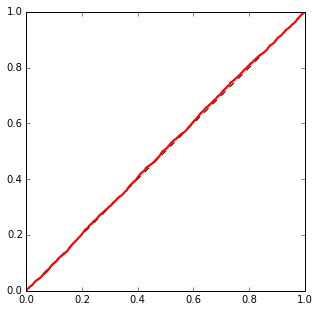

In [20]:
r, auc = estimate_quality(test, random_ranker, True)
results.append({
        'name': 'random',
        'auc': auc,
        'recall_at_k': r,
    })
print 'Quality of random ranker:', auc

Кривая Recall@k стремится к прямой, если ранжирование не зависит от релевантности. Базовое значение AUC — 0.5, его будем пытаться улучшить.

### Ранжирование по популярности

Определим по обучающим данным популярность каждой закладки, будем предлагать пользователю закладки в порядке убывания их популярности (не зависимо от пользователя).

In [21]:
train_bookmark_counts = train_user_bookmarks.bookmarkID.value_counts()
train_bookmark_counts.name = 'occurrences'
train_bookmarks = bookmarks.join(train_bookmark_counts)

In [22]:
train_bookmarks[['title', 'url', 'occurrences']].dropna().sort('occurrences', ascending=False).head(n=10)

,title,url,occurrences
id,,,
5448,HTML5 Boilerplate - A rock-solid default for H...,http://html5boilerplate.com/,25
1752,Eric Butler - Software Developer in Seattle WA,http://codebutler.com/firesheep,24
2720,Prezi - The zooming presentation editor,http://prezi.com/,20
1087,Draw on any webpage. Share your ideas. - MarkUp,http://markup.io/,20
5191,the creative internet (106 things),https://docs.google.com/present/view?id=0Abmo0...,19
2178,Wordle - Beautiful Word Clouds,http://www.wordle.net/,19
4041,Ultimate CSS Gradient Generator - ColorZilla.com,http://www.colorzilla.com/gradient-editor/,18
7535,visualizing.org,http://www.visualizing.org/,18
1303,TNS Digital Life | Internet Statistics &amp; S...,http://discoverdigitallife.com/,18


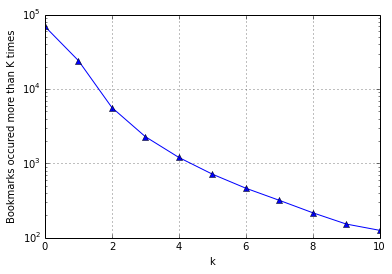

In [23]:
ks, bookmarks_k = arange(11), zeros(11)
for k in ks:
    bookmarks_k[k] = bookmark_counts[bookmark_counts > k].shape[0]
semilogy(bookmarks_k, '-^')
grid(True)
xlabel('k')
ylabel('Bookmarks occured more than K times')

In [24]:
def popularity_ranker(test):
    return bookmark_counts[test.bookmarkID].fillna(value=+inf)

Quality of popularity ranker: 0.591899659413


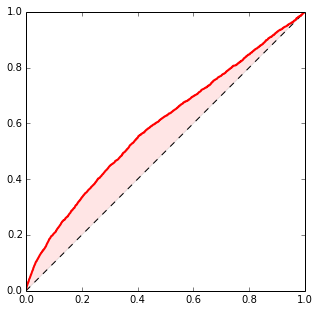

In [25]:
r, auc = estimate_quality(test, popularity_ranker, True)
results.append({
        'name': 'popularity',
        'auc': auc,
        'recall_at_k': r,
    })
print 'Quality of popularity ranker:', auc

Ранжирование по популярности работает лучше чем случайное перемешивание.

### Ранжирование по тегам

Выделить список тегов у пользователя, выделить список тегов у закладки. Оценка – величина пересечения множеств тегов.

In [26]:
def tag_ranker(test):
    pass

### Коллаборативная фильтрация пар пользователь–закладка

Поставим каждому 

In [27]:
unique_userIDs = unique(train_user_bookmarks.userID.values)
user_index_map = zeros(unique_userIDs.max() + 1, dtype=int)
user_index_map[unique_userIDs] = arange(len(unique_userIDs), dtype=int)

unique_bookmarkIDs = unique(train_user_bookmarks.bookmarkID.values)
bookmark_index_map = zeros(unique_bookmarkIDs.max() + 1, dtype=int)
bookmark_index_map[unique_bookmarkIDs] = arange(len(unique_bookmarkIDs), dtype=int)

data = (user_index_map[train_user_bookmarks.userID.values], bookmark_index_map[train_user_bookmarks.bookmarkID.values])

In [28]:
import simplesvd
reload(simplesvd)
X, Y = simplesvd.svd_als(data, rank=20, c_default=0.05, p_default=-1, penalty=1e-2, verbose=True, iters=5)

Preparing the data...
Starting iterations...
Iter 1: J=394097.66 RMSE(R)=1.54203072
Iter 2: J=307640.21 RMSE(R)=1.50705353
Iter 3: J=304818.28 RMSE(R)=1.49735563
Iter 4: J=303169.81 RMSE(R)=1.49120688
Iter 5: J=301924.74 RMSE(R)=1.48621419


In [29]:
def svd_ranker(test):
    global X, Y
    userIdx = user_index_map[test.userID.values]
    bookmarkIdx = bookmark_index_map[test.bookmarkID.values]
    return (X[userIdx, :] * Y[bookmarkIdx, :]).sum(axis=1).T

Quality of SVD-based ranker: 0.710194752246


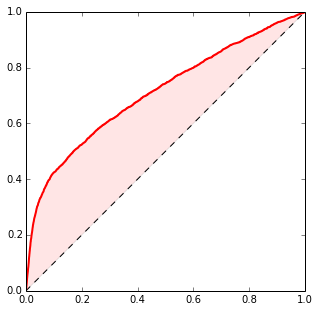

In [30]:
r, auc = estimate_quality(test, svd_ranker, True)
results.append({
        'name': 'svd',
        'auc': auc,
        'recall_at_k': r,
    })
print 'Quality of SVD-based ranker:', auc

## Сравнение результатов

    random: 0.503976
popularity: 0.591900
       svd: 0.710195


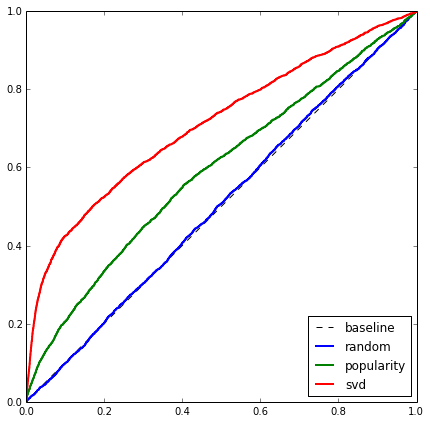

In [48]:
figure(figsize=(7, 7))
plot([0, 1], [0, 1], 'k--')
names = ['baseline']
for res in results:
    recall_at_k = res['recall_at_k']
    names.append(res['name'])
    plot(linspace(0, 1, len(recall_at_k)), recall_at_k, linewidth=2)
    print '%10s: %f' % (res['name'], res['auc'])
xlim([0, 1])
ylim([0, 1])
legend(names, 'lower right')

## Составление списков рекомендаций

Выберем обученный SVD-ранкер:

In [32]:
ranker = svd_ranker

Будем для каждого пользователя предсказывать предпочтение ко всем закладкам. Это может занять длительное время. Для ускорения можно производить отсев закладок-кандидатов <tt>(candidates)</tt> при помощи простой быстро работающей модели или эвристического правила.

In [33]:
N_RECOMMEND = 5

recommendations = {}
bookmarks_by_user = user_bookmarks.groupby('userID')
users_processed = 0
for userID, group in bookmarks_by_user.groups.iteritems():
    candidate_bookmarkIDs = setdiff1d(array(bookmarks.index), user_bookmarks.ix[group, 'bookmarkID'].values)
    candidates = pandas.DataFrame({
        'userID': userID,
        'bookmarkID': candidate_bookmarkIDs,
    })
    preferences = ranker(candidates)
    recommendations[userID] = candidates.ix[argsort(preferences)[::-1][:N_RECOMMEND], 'bookmarkID'].values
    
    users_processed += 1
    if users_processed % 100 == 0: 
        print 'Users processed:', users_processed
    

Users processed: 100
Users processed: 200
Users processed: 300
Users processed: 400
Users processed: 500
Users processed: 600
Users processed: 700
Users processed: 800
Users processed: 900
Users processed: 1000
Users processed: 1100
Users processed: 1200
Users processed: 1300
Users processed: 1400
Users processed: 1500
Users processed: 1600
Users processed: 1700
Users processed: 1800


### Вывод в файл

In [34]:
with open('recommendations.txt', 'w') as f:
    for userID, bookmarkIDs in recommendations.iteritems():
        f.write(str(userID) + '\t' + ','.join(map(str, bookmarkIDs)) + '\n')

In [35]:
!head recommendations.txt

90113	4264,5328,8765,3827,156
49159	28843,10000,1922,21321,8613
8	1631,10742,14121,29097,28843
16394	1293,4806,17928,25488,3576
106507	1752,8223,1712,1973,4493
57359	5448,1087,1752,49957,20624
8216	5845,17016,5855,3112,16996
65563	5448,4264,19249,4795,8936
32	59,20624,10742,35,2178
90145	4264,11918,2178,5177,6290


### Посмотреть на рекомендации

In [36]:
userID = 8

user_bg = user_taggedbookmarks[user_taggedbookmarks.userID == userID]

Теги, используемые пользователем:

In [37]:
tag_cnt = user_bg.tagID.value_counts()
tags = pandas.DataFrame({'tag': tag_names.ix[tag_cnt.index, 'value'], 'count': tag_cnt.values})
tags.head(n=10)

,count,tag
1,28,collection_development
45,8,media_awareness
2,7,library
24,6,librarian
76,4,internet_safety
82,4,students
25,4,literacy
66,3,learning
56,2,web_20
44,2,librarianship_part1


Наиболее популярные закладки пользователя:

In [38]:
print 'Bookmarks:'
frame = {'title': [], 'domain': [], 'tags': [], 'occurrences': []}
for bookmarkID, group in user_bg.groupby('bookmarkID').groups.iteritems():
    title = bookmarks.ix[bookmarkID, 'title']
    domain = bookmarks.ix[bookmarkID, 'urlPrincipal']
    tagIDs = user_bg.ix[group, 'tagID'].values
    tags = map(lambda tagID: tag_names.ix[tagID, 'value'], tagIDs)
    frame['title'].append(title)
    frame['domain'].append(domain)
    frame['tags'].append(', '.join(tags))
    frame['occurrences'].append(bookmark_counts[bookmarkID])
    
pandas.DataFrame(frame).sort('occurrences', ascending=False).head(n=10)

Bookmarks:


,domain,occurrences,tags,title
23,edublogs.org,16,"collection_development, education_blogs",Edublogs - teacher and student blogs
37,www.classroom20.com,13,web_20,Classroom 2.0
31,www.canlitforkids.com,11,canada_literature_for_kids,Welcome to CanLit for Kids
44,www.netsmartz.org,9,"media_awareness, internet_safety, how_to_be_ne...",NetSmartz.org
28,www.allthingsplc.info,7,professional_learning_communities,"AllThingsPLC — Research, education tools and b..."
39,www.schoolinfo.ca,5,"collection_development, technology",connection education with how young people use...
66,www.ala.org,5,library,ALA | AASL Best Web sites for Teaching and Lea...
12,www.ixl.com,5,"collection_development, math",IXL Math
48,www.readprint.com,4,"librarian, e-books, students, teachers","Online Books, Poems, Short Stories - Read Print"
49,www.media-awareness.ca,4,"media_awareness, internet_safety, games_that_e...",Jo Fool or Jo Cool | For Teachers


Сгенерированные рекомендации:

In [39]:
bookmarks.ix[recommendations[userID], ['title', 'urlPrincipal']].head()

,title,urlPrincipal
1631,animoto - the end of slideshows,animoto.com
10742,Tagxedo - Tag Cloud with Styles,www.tagxedo.com
14121,TeacherTube - Teach the World | Teacher Videos...,www.teachertube.com
29097,Information Literacy Resources | November Lear...,novemberlearning.com
28843,Storybird - Collaborative storytelling,storybird.com
